# Indonesia Spam Message Classifier

This tutorial follow along with this reference: [link](https://luthfipedia.xyz/klasifikasi-spam-sms-menggunakan-naive-bayes/)

Original dataset: [link](https://yudiwbs.wordpress.com/2018/08/05/dataset-klasifikasi-bahasa-indonesia-sms-spam-klasifikasi-teks-dengan-scikit-learn/)

Download dataset: [link](https://drive.google.com/file/d/17Xp0cTZCtIKk5olePOvQDm9hurWwTCGS/view?usp=sharing)



## Modules & Library

In [1]:
# Install PySastrawi libraries that used for reducing inflected word

!pip install PySastrawi

You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

## Dataset

Remember you can download the dataset [here](https://drive.google.com/file/d/17Xp0cTZCtIKk5olePOvQDm9hurWwTCGS/view?usp=sharing)

In [3]:
data = 'dataset_sms_spam_v1.csv'

df = pd.read_csv(data)
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


## Interacting With Data

In [4]:
# To define the length and the number of column from dataset
df.shape

(1143, 2)

In [5]:
# More detailed about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [6]:
df.isnull().sum()

Teks     0
label    0
dtype: int64

In [7]:
df.groupby('label').count()

,Teks
label,
0,569
1,335
2,239


<AxesSubplot:xlabel='label'>

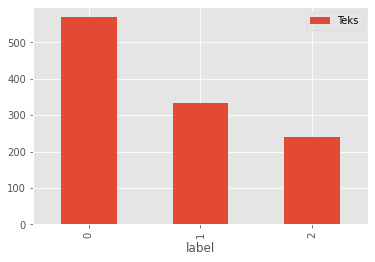

In [8]:
df.groupby('label').count().plot(kind='bar')

**NOTE**

0: Normal message <br />
1: Spam message <br />
2: Promotion message <br />

## Text Preprocessing

In [9]:
# Using PySastrawi to remove all special character within Text so the machine will understand

streams = StemmerFactory().create_stemmer()
stream_word = []
for i in df['Teks']:
  stream = streams.stem(i)
  stream_word.append(stream)
stream_word[:3] 

['promo beli paket flash mulai 1gb di my telkomsel app dpt extra kuota 2gb 4g lte dan extra nelpon hingga 100mnt 1hr buru cek di tsel me mytsel1 s k',
 '2 5 gb 30 hari hanya rp 35 ribu spesial buat anda yang pilih aktif sekarang juga di 550 905 promo sd 30 nov 2015 buru aktif sekarang s k',
 '2016-07-08 11 47 11 plg yth sisa kuota flash anda 478kb download mytelkomsel apps di http tsel me tsel utk cek kuota beli paket flash atau hub 363']

In [10]:
type(stream_word)

list

We can't process list data, so we need to turn it into dataframe

In [11]:
from pandas import DataFrame

df_stream = DataFrame(stream_word, columns=['stream_text'])

In [12]:
df_stream.head()

,stream_text
0,promo beli paket flash mulai 1gb di my telkoms...
1,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...
2,2016-07-08 11 47 11 plg yth sisa kuota flash a...
3,2016-08-07 11 29 47 plg yth sisa kuota flash a...
4,4 5gb 30 hari hanya rp 55 ribu spesial buat an...


In [13]:
type(df_stream)

pandas.core.frame.DataFrame

In [14]:
# TF-IDF (Term Frequency – Inverse Document Frequency)
# It used for giving weighting within a text

vectorizer = TfidfVectorizer(max_features=1000, 
                            decode_error='ignore')
vectorizer.fit(df_stream['stream_text'])

TfidfVectorizer(decode_error='ignore', max_features=1000)

In [15]:
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [16]:
df_stream = df_stream.join(df['label'])

In [17]:
df_stream.head()

,stream_text,label
0,promo beli paket flash mulai 1gb di my telkoms...,2
1,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2
2,2016-07-08 11 47 11 plg yth sisa kuota flash a...,2
3,2016-08-07 11 29 47 plg yth sisa kuota flash a...,2
4,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,2


## Accuracy Test

In [18]:
def naive_bayes(x_train, x_test, y_train, y_test):
  nbs = MultinomialNB()
  x = np.arange(len(df_stream))

  nbs.fit(vectorizer.transform(x_train), y_train)
  y_pred = nbs.predict(vectorizer.transform(x_test))
  score = accuracy_score(y_test, y_pred)
  return score

K-Fold Check

In [19]:
kf = KFold(n_splits=5, random_state=True, shuffle=True)

train, test = [], []
i = 1
accuracy = []
x = np.arange(len(stream_word))

for train_index, test_index in kf.split(x):
  x_train = df_stream['stream_text'][train_index]
  x_test = df_stream['stream_text'][test_index]
  y_train = df_stream['label'][train_index]
  y_test = df_stream['label'][test_index]

  score = naive_bayes(x_train, x_test, y_train, y_test)
  accuracy.append(score)
  print('KFold', i, score)
  i += 1

accuracy = np.array(accuracy)
print(f"Average Score: {round(accuracy.sum()/len(accuracy) * 100, 2)}")

KFold 1 0.9170305676855895
KFold 2 0.9301310043668122
KFold 3 0.9388646288209607
KFold 4 0.9429824561403509
KFold 5 0.9385964912280702
Average Score: 93.35


## Predict Test

In [20]:
test_word = [
        "Buruan Download & Registrasi myCare di http://bit.ly/mycarepLy dan dapatkan Promo 10GB (4G) di Paket Freedoom M & L dengan harga khusus HANYA HARI INI",
        "Gunakan Grab dan nikmati 75% diskon untuk 10x bagi pengguna baru. Masukkan kode COBAGRABCAR sekarang juga dan ajak teman-temanmu keliling bandung tanpa pusing",
        "Kalo kata raditya dika tuh cara pandang org ttg cinta akan berubah setelah mengalami patah hati terhebat. Haha",
        "Kasih norek aja kesebelah. Siapa tau ada yg mau. Mereka jg punya hak untk udunan wkwk. Bilang bts waktu trfr. Kalau ada niat pasti segera kok.",
        "Lelah byr min payment? Kami Solusinya, bantu secara LEGAL penutupan CC/KTA, dscn 50-75%. Hub.LoLyta 081316523061/087822962308 (WA). LEGAL",
        "Anda brminat cash&kredit mtor scond brg istmwa tipe&merk apa sj.dsini mnyediakn 50 unit dr thn 2004 keatas hub 087739124242/085743146233 MS DEDIKTP luar yk bs.",
        "Kamu cantik tapi sayang bukan milikku"
]

In [21]:
nbs = MultinomialNB()
nbs.fit(vectorizer.transform(x_train), y_train)

for i in test_word:
  predict_class = nbs.predict(vectorizer.transform([i]))
  print(i)
  if predict_class == 0:
    print('normal message')
  elif predict_class == 1:
    print('spam detected')
  else:
    print('promotion message')
  print() 

Buruan Download & Registrasi myCare di http://bit.ly/mycarepLy dan dapatkan Promo 10GB (4G) di Paket Freedoom M & L dengan harga khusus HANYA HARI INI
promotion message

Gunakan Grab dan nikmati 75% diskon untuk 10x bagi pengguna baru. Masukkan kode COBAGRABCAR sekarang juga dan ajak teman-temanmu keliling bandung tanpa pusing
promotion message

Kalo kata raditya dika tuh cara pandang org ttg cinta akan berubah setelah mengalami patah hati terhebat. Haha
normal message

Kasih norek aja kesebelah. Siapa tau ada yg mau. Mereka jg punya hak untk udunan wkwk. Bilang bts waktu trfr. Kalau ada niat pasti segera kok.
normal message

Lelah byr min payment? Kami Solusinya, bantu secara LEGAL penutupan CC/KTA, dscn 50-75%. Hub.LoLyta 081316523061/087822962308 (WA). LEGAL
spam detected

Anda brminat cash&kredit mtor scond brg istmwa tipe&merk apa sj.dsini mnyediakn 50 unit dr thn 2004 keatas hub 087739124242/085743146233 MS DEDIKTP luar yk bs.
spam detected

Kamu cantik tapi sayang bukan milikku


** **CONCLUSION** **

As you can see, we got the accuracy 93.35% using this model